# Identificação de Clientes de Alto Valor

## Planejamento da Solução

### Entrada

O problema de negócio
1. Selecionar os mais valiosos clientes para formar o programa de fidelidade "INSIDERS"
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

### Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".
2. Relatório com as respostas para as seguintes perguntas:
- Quem são as pessoas elegíveis para participar do programa de Insiders ?
- Quantos clientes farão parte do grupo ?
- Quais as principais características desses clientes ?
- Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
- Qual a expectativa de faturamento desse grupo para os próximos meses ?
- Quais as condições para uma pessoa ser elegível ao Insiders ?
- Quais as condições para uma pessoa ser removida do Insiders ?
- Qual a garantia que o programa Insiders é melhor que o restante da base ?
- Quais ações o time de marketing pode realizar para aumentar o faturamento ?

### Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível? O que são clientes de maior valor?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV (Life Time Value)
        - Baixo recência
        - Alto basket size (quantidade média de produtos comprados)
        - Baixa probabilidade de Churn
        - Previsão alta de LTV
        - Alta propensão de compra
    - Custo:
        - Baixa taxa de devolução
        
    - Experiência:
        - Alta média de avaliação
2. **Quantos clientes farão parte do grupo?**
     - Número de clientes
     - Porcentagem do total
     
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - Localização
        - Salário
    - Escrever as principais característica de consumo
        - Atributos de Clusterização

4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Faturamento total do ano
    - Faturamento do grupo de Insiders

5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - LTV do grupo Insiders
    - Série temporais (ARMA, ARIMA, HoltWinter, etc)

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Definir a periodicidade (1 mês, 2 meses, 3 meses...)
    - A pessoa precisa de parecido/similiar com outras que já estão no grupo

7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - Definir a periodicidade (1 mês, 2 meses, 3 meses...)
    - A pessoa não ser parecido/similiar com outras que já estão no grupo    

8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste A/B
    - Teste A/B de Bayesiano
    - Teste de hipótese
        
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento ?**
    - Desconto
    - Preferências de escolha
    - Produtos exclusivos

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import umap
import re

import seaborn as sns
from matplotlib import pyplot as plt


from sklearn.cluster       import KMeans
from sklearn.metrics       import silhouette_score
from sklearn.preprocessing import StandardScaler
from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Loading

In [2]:
data = pd.read_csv('datasets/ecommerce.csv', encoding='unicode_escape')

In [3]:
# drop de coluna
data = data.drop('Unnamed: 8', axis=1)

# 1 Descrição dos Dados

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Renomeando as Colunas

In [5]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
old_cols = list(data.columns)

new_cols = []

for c in old_cols:
    new_cols.append(inflection.underscore(c))

data.columns = new_cols

In [7]:
data.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 Tamanho do Conjunto de Dados 

In [8]:
print(f'Linhas: {data.shape[0]}')
print(f'Colunas: {data.shape[1]}')

Linhas: 541909
Colunas: 8


## 1.3 Tipos dos Dados

In [9]:
data.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
data.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA's

Para preencher os 'customer_id' faltantes e não perder todas as informações dessas 135080 linhas do DF faremos o seguinte:
Cada compra que não possui customer_id faremos uma associação com invoice_no, de tal forma que cada invoice_no será associado a um customer_id novo.

In [12]:
# customer_id max
data['customer_id'].max()

18287.0

Os novos customer_id serão maiores que 18287, vamos começar a partir de 18500. Assim garantiremos que não haverá repetição de customer_id

In [13]:
# criação de um dicionário com os novos customer_id {'invoice_no': novo_customer_id}
invoice_customer_id_null = list(data[data['customer_id'].isna()]['invoice_no'].drop_duplicates())

customer_id_null_dic = {}
new_customer_id = 18500
for invoice in invoice_customer_id_null:
    customer_id_null_dic[invoice] = new_customer_id
    new_customer_id += 1


In [14]:
# Nova coluna de customer_id, com invoice_no no lugar do customer_id
data['new_customer_id'] = data[['invoice_no', 'customer_id']].apply(lambda x: x['invoice_no'] if 
                                          np.isnan(x['customer_id']) == True else np.nan, axis=1)

In [15]:
data.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,new_customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [16]:
# faz a troca de cada invoice_no pelo novo customer_id com o dicionário criado
data['new_customer_id'] = data['new_customer_id'].map(customer_id_null_dic)

In [17]:
# junta as colunas customer_id e new_customer_id em uma só
data['customer_id'] = data[['customer_id', 'new_customer_id']].apply(lambda x: x['new_customer_id'] 
                                                                     if np.isnan(x['customer_id'])  == True 
                                                                     else x['customer_id'] , axis=1)

In [18]:
# drop new_customer_id
data = data.drop('new_customer_id', axis=1)

In [19]:
data.isnull().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
customer_id        0
country            0
dtype: int64

## 1.6 Troca dos Tipos dos Dados

In [20]:
# invoice_date
data['invoice_date'] = pd.to_datetime(data['invoice_date'], format='%d-%b-%y')

# customer_id
data['customer_id'] = data['customer_id'].astype('int64')


## 1.7 Estatística Descritiva

In [21]:
num_attributes = data.select_dtypes(include=['int64', 'float64'])
cat_attributes = data.select_dtypes(include=['object'])

## 1.7.1 Atributos Numéricos

In [22]:
# Medidas de Tedência Central - Média e Mediana
tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
tc2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Medidas de Dispersão - Desvio Padrão, Mínimo, Máximo, Range, Assimetria (skew) e Curtose
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:  np.max(x) - np.min(x))).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
est_desc_num = pd.concat([d2, d3, d4, tc1, tc2, d1, d5, d6]).T.reset_index()

# Renomear
est_desc_num.columns = ['attribute', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']

In [24]:
est_desc_num

,attribute,min,max,range,media,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22209.0,9863.00,16564.206981,16249.00,2733.348518,0.410621,-0.824543


#### 1.7.1.1 Investigando os atributos numéricos

Coisas que estão estranhas:
- Quantidade negativa (pode ser devolução)
- Preço unitário igual a zero (pode ser promoção/brinde)

### 1.7.2 Atributos Categóricos

In [25]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### 1.7.2.1 Invoice_no

In [26]:
lista = []
for c in data.loc[data['invoice_no'].apply(lambda x: bool(re.search('[a-zA-Z]+', x))), 'invoice_no'].unique():
    lista.append(c[0])
set(lista)

{'A', 'C'}

Todos os invoice_no que começam com a letra 'C' possuem quantity negativo. Isso pode significar 'Cancel', 'Change' ou 'Chargeback'.

In [34]:
data.loc[data['invoice_no'].apply(lambda x: bool(re.search('A.', x))), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,20997,United Kingdom
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,20998,United Kingdom
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,20999,United Kingdom


In [35]:
data[data['unit_price'] < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,20998,United Kingdom
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,20999,United Kingdom


Todos os inovice_no que começam com 'A' são descritos como 'Adjust bad debt' e 2 deles possuem unit_price negativo. São apenas três linhas, excluiremos esses dados.

In [39]:
df_stock = data[['stock_code', 'quantity']].groupby('stock_code').sum().reset_index()
df_stock[df_stock['quantity'] < 0].head()

,stock_code,quantity
3,10123C,-13
4,10123G,-38
9,10134,-19
46,16053,-102
55,16162L,-4


Existem  produtos que foram mais Cancelados ou Trocados do que comprados.  (!?!?!)

#### 1.7.2.2 Stock_code

In [40]:
data.loc[data['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+', x))), :]['stock_code'].unique()

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [276]:
data[data['stock_code'] == 'POST'].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
377896,569568,POST,POSTAGE,5,2017-10-03,18.0,12700,France


stock_code = 'POST' pode representar envio de carta.

In [277]:
data[(data['stock_code'] == 'D')].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
140555,C548411,D,Discount,-1,2017-03-29,162.24,13316,United Kingdom


stock_code = 'D' representa algum tipo de desconto que o cliente recebeu.

In [278]:
data[(data['stock_code'] == 'C2')].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
274448,560916,C2,CARRIAGE,1,2017-07-19,50.0,14911,EIRE


stock_code = 'C2' pode representar algum tipo de frete.

In [65]:
data[(data['stock_code'].isin(['M', 'm']))]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
2239,536569,M,Manual,1,2016-11-29,1.25,16274,United Kingdom
2250,536569,M,Manual,1,2016-11-29,18.95,16274,United Kingdom
5684,536865,M,Manual,1,2016-12-01,2.55,18525,United Kingdom
6798,536981,M,Manual,2,2016-12-01,0.85,14723,United Kingdom
7976,537077,M,Manual,12,2016-12-03,0.42,17062,United Kingdom
...,...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,2017-12-04,1.25,17841,United Kingdom
533082,C581009,M,Manual,-1,2017-12-05,125.00,16971,United Kingdom
534308,C581145,M,Manual,-1,2017-12-05,9.95,17490,United Kingdom
538321,581405,M,Manual,3,2017-12-06,0.42,13521,United Kingdom


stock_code = 'M' ou 'm' tem  descrição 'Manual', talvez sejam itens que foram acrescentados manualmente.

In [280]:
data[data['stock_code'] == 'BANK CHARGES'].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
431351,573586,BANK CHARGES,Bank Charges,1,2017-10-29,15.0,14704,United Kingdom


stock_code = 'BANK CHARGES' deve ser alguma taxa de banco, porem são pouquissímos resultados com essa característica, podemos  descarta-los sem nenhuma preocupação.

In [281]:
data[data['stock_code'] == 'PADS']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,13952,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-07-24,0.001,15618,United Kingdom
358655,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.000,16133,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.001,16198,United Kingdom


stock_code = 'PADS' podemos descartar sem nenhuma preocupação.

In [282]:
data[data['stock_code'] == 'DOT'].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
467436,576339,DOT,DOTCOM POSTAGE,1,2017-11-12,1500.36,14096,United Kingdom


stock_code = 'DOT' é algum tipo de postagem, mas que diferente do 'POST' possui valores bem maiores e apenas  um cliente utilizou esse tipo de postagem (cliente com customer_id = 14096).

In [283]:
data[(data['stock_code'] == 'CRUK')].sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
324023,C565382,CRUK,CRUK Commission,-1,2017-08-31,13.01,14096,United Kingdom


CRUK (Cancer Research UK) Commission: Todos os 'stock_code' == 'CRUK' possuem quantity negativa, o que deve significar um desconto/taxa/doação para a instituição Cancer Research UK.

In [48]:
data[(data['stock_code'] == 'S')].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
14436,C537581,S,SAMPLES,-1,2016-12-05,12.95,18600,United Kingdom
14437,C537581,S,SAMPLES,-1,2016-12-05,52.00,18600,United Kingdom
96680,C544580,S,SAMPLES,-1,2017-02-19,5.74,19207,United Kingdom
96681,C544580,S,SAMPLES,-1,2017-02-19,11.08,19207,United Kingdom
96682,C544580,S,SAMPLES,-1,2017-02-19,5.79,19207,United Kingdom


stock_code = 'S' possuem descrição 'SAMPLES', o que deve significar que são amostras de determinado produto. Todos as linhas são de clientes com customer_id > 18500, ou seja, são clientes que não estavam na base de dados inicialmente. Vamos dropar.

In [53]:
data[data['stock_code'] == 'AMAZONFEE'].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
14514,C537600,AMAZONFEE,AMAZON FEE,-1,2016-12-05,1.00,18601,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13541.33,18605,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,2016-12-05,13541.33,18606,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13474.79,18616,United Kingdom
16313,C537647,AMAZONFEE,AMAZON FEE,-1,2016-12-05,5519.25,18617,United Kingdom


'AMAZONFEE' deve tratar sobre algumas taxa da Amazon. Todos as linhas são de clientes com customer_id > 18500, ou seja, são clientes que não estavam na base de dados inicialmente. Vamos dropar.

In [56]:
data.loc[data['stock_code'].apply(lambda x: bool(re.search('DCGS.', x))), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
21326,538071,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,1,2016-12-07,16.13,18654,United Kingdom
24906,538349,DCGS0003,BOXED GLASS ASHTRAY,1,2016-12-08,2.51,18695,United Kingdom
36460,539451,DCGS0003,BOXED GLASS ASHTRAY,1,2016-12-15,2.51,18744,United Kingdom
39313,539631,DCGS0076,SUNJAR LED NIGHT NIGHT LIGHT,2,2016-12-18,16.13,18764,United Kingdom
40052,539718,DCGS0070,CAMOUFLAGE DOG COLLAR,1,2016-12-19,12.72,18777,United Kingdom


stock_code que começam com DCGS parecem compras normais. Todos as linhas são de clientes com customer_id > 18500, ou seja, são clientes que não estavam na base de dados inicialmente. Não vamos dropar.

In [60]:
data.loc[data['stock_code'].apply(lambda x: bool(re.search('gift.', x))), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
38248,539492,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00,1,2016-12-18,34.04,18753,United Kingdom
42057,539958,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,2016-12-21,42.55,18809,United Kingdom
44725,540238,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00,1,2017-01-03,25.53,18841,United Kingdom
44794,540238,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2017-01-03,17.02,18841,United Kingdom
55589,540995,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2017-01-11,16.67,18900,United Kingdom


stock_code que começam com 'gift' são compras de voucher de presente. Todos as linhas são de clientes com customer_id > 18500, ou seja, são clientes que não estavam na base de dados inicialmente. Não vamos dropar.

In [66]:
data[data['stock_code'] == 'B']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,20997,United Kingdom
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,20998,United Kingdom
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,20999,United Kingdom


stock_code = 'B' são as mesmas linhas que possuem invoice_no começando com 'A', que já discutimos anteriormente  e serão dropadas.

Diante disso faremos as seguintes considerações:
- Vamos 'dropar' as  linhas com os stock_code: 'POST', 'C2', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'B'.
- Vamos deixar as linhas com os stock_code: 'D', 'M', 'DCGS...', 'gift...' 
- O cliente 14096 possui valores alto com 'DOT' e 'CRUK' que estamos dropando, ficaremos atentos nesse cliente em específico.

#### 1.7.2.3 Description

Não utilizaremos a descrição.

#### 1.7.2.4 Country

In [68]:
data['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [69]:
len(data['country'].unique())

38

São 38 países.

In [71]:
data['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

# 2 Filtragem de Variáveis

In [83]:
df2 = data.copy()

In [84]:
# Unit_price: maiores que 0.04
df2 = df2[df2['unit_price'] > 0.04]

# stock_code: drop 'POST', 'C2', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'
df2 = df2[~df2['stock_code'].isin(['POST', 'C2', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 'S', 'AMAZONFEE', 'B'])]

# description: drop da coluna
df2 = df2.drop('description', axis=1)

# country: drop de 'European Community' e 'Unspecified' (idéia para os próximos ciclos)
# df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2[df2['quantity'] < 0].copy()
df2_purchases = df2[df2['quantity'] >= 0].copy()



In [85]:
df2.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.39,17850,United Kingdom


# 3 Features Engineering

In [86]:
df3 = df2.copy()

In [87]:
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1)
df_ref = df_ref.drop_duplicates().reset_index(drop=True)

## 3.1 Criação de Features

### 3.1.1 Faturamento

In [88]:
# Monetary
df2_purchases['monetary'] = df2_purchases['unit_price']*df2_purchases['quantity']
df_monetary = df2_purchases[['customer_id', 'monetary']].groupby('customer_id').sum().reset_index()

# join
df_ref = df_ref.merge(df_monetary, how='left', on='customer_id')

### 3.1.2 Recência  (Quantidade de dias desde de última compra)

In [90]:
# Recency (Recência) - Quantidade de dias desde a última compra
df2_purchases['recency_days'] = df2_purchases['invoice_date'].max() - df2_purchases['invoice_date']
df_recency = df2_purchases[['customer_id', 'recency_days']].groupby('customer_id').min().reset_index()
df_recency['recency_days'] = df_recency['recency_days'].dt.days     # extrai o dia como int64

# join
df_ref = df_ref.merge(df_recency, how='left', on='customer_id')


### 3.1.3 Quantidade de compras realizadas

In [ ]:
# Frequency
df_freq = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_freq.columns = ['customer_id', 'frequency']

# Join
df_ref = df_ref.merge(df_freq, how='left', on='customer_id')

### 3.1.4 Quantidade de produtos comprados

In [ ]:
df_quant = df2_purchases[['customer_id', 'quantity']].drop_duplicates().groupby('customer_id').count().reset_index()

# Join
df_ref = df_ref.merge(df_quant, how='left', on='customer_id')

### 3.1.5 Ticket Médio

In [ ]:
# AVG Ticket
df_avg_ticket = df2_purchases[['customer_id', 'monetary']].groupby('customer_id').mean().reset_index().rename(columns={'monetary': 'avg_ticket'})

# Join
df_ref = df_ref.merge(df_avg_ticket, how='left', on='customer_id')

### 3.1.6 Recência média entre as compras

### 3.1.7 Devoluções

### 3.1.8 Média da quantidade de produtos por compra

In [296]:
df_ref.head()

,customer_id,monetary,recency_days,frequency,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3237.54,31.0,10.0,18.822907
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


In [297]:
# Check NAs
df_ref.isna().sum()

customer_id      0
monetary        34
recency_days    34
frequency       34
avg_ticket      34
dtype: int64

Para esse ciclo vamos dropar essas 34 linhas com NA's.

# 4 Análise Exploratória dos Dados

In [298]:
df4 = df_ref.dropna().copy()

In [299]:
df4.isna().sum()

customer_id     0
monetary        0
recency_days    0
frequency       0
avg_ticket      0
dtype: int64

# 5 Preparação dos Dados

In [300]:
df5 = df4.copy()

In [301]:
ss = StandardScaler()

In [302]:
df5['monetary'] = ss.fit_transform(df5[['monetary']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])


In [303]:
df5.head()

,customer_id,monetary,recency_days,frequency,avg_ticket
0,17850,0.376325,2.799894,3.876667,-0.034218
1,13047,0.135025,-0.611005,0.748478,-0.033761
2,12583,0.523565,-0.901081,1.400184,-0.026895
3,13748,-0.121469,0.029164,0.096772,-0.023514
4,15100,-0.129564,2.409791,-0.163911,0.152333


# 6 Seleção dos Atributos

In [304]:
df6 = df5.copy()

# 7 Hyperparameter Fine-Tunning

In [305]:
df7 = df6.copy()

In [306]:
X = df7.drop('customer_id', axis=1)

In [307]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Square (WSS)

### 7.1.1 Sem usar a Biblioteca  Yellowbrick

Text(0.5, 1.0, 'WSS vs K')

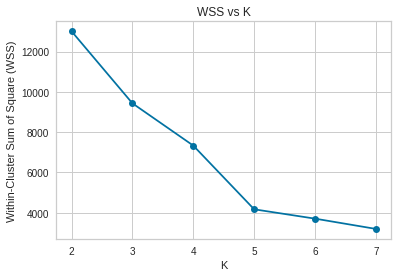

In [308]:
wss = []

for k in clusters:
    # model definition
    kmeans = KMeans(init = 'random', n_clusters=k, n_init=10, max_iter=300, random_state=271)
    
    # model training
    kmeans.fit(X)
    
    # validation
    wss.append(kmeans.inertia_)
    
# plot

plt.plot(clusters, wss, linestyle='-', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square (WSS)')
plt.title('WSS vs K')
    

### 7.1.2 Usando a Biblioteca Yellowbrick

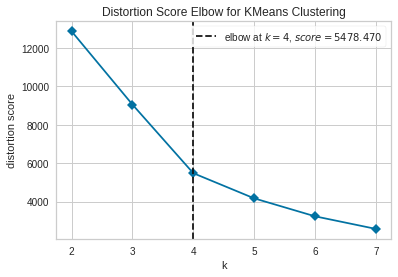

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [309]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Score

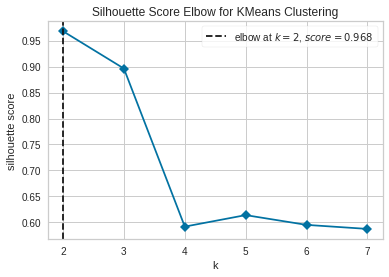

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [310]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric = 'silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

### 7.2.1 Análise da Silhueta 

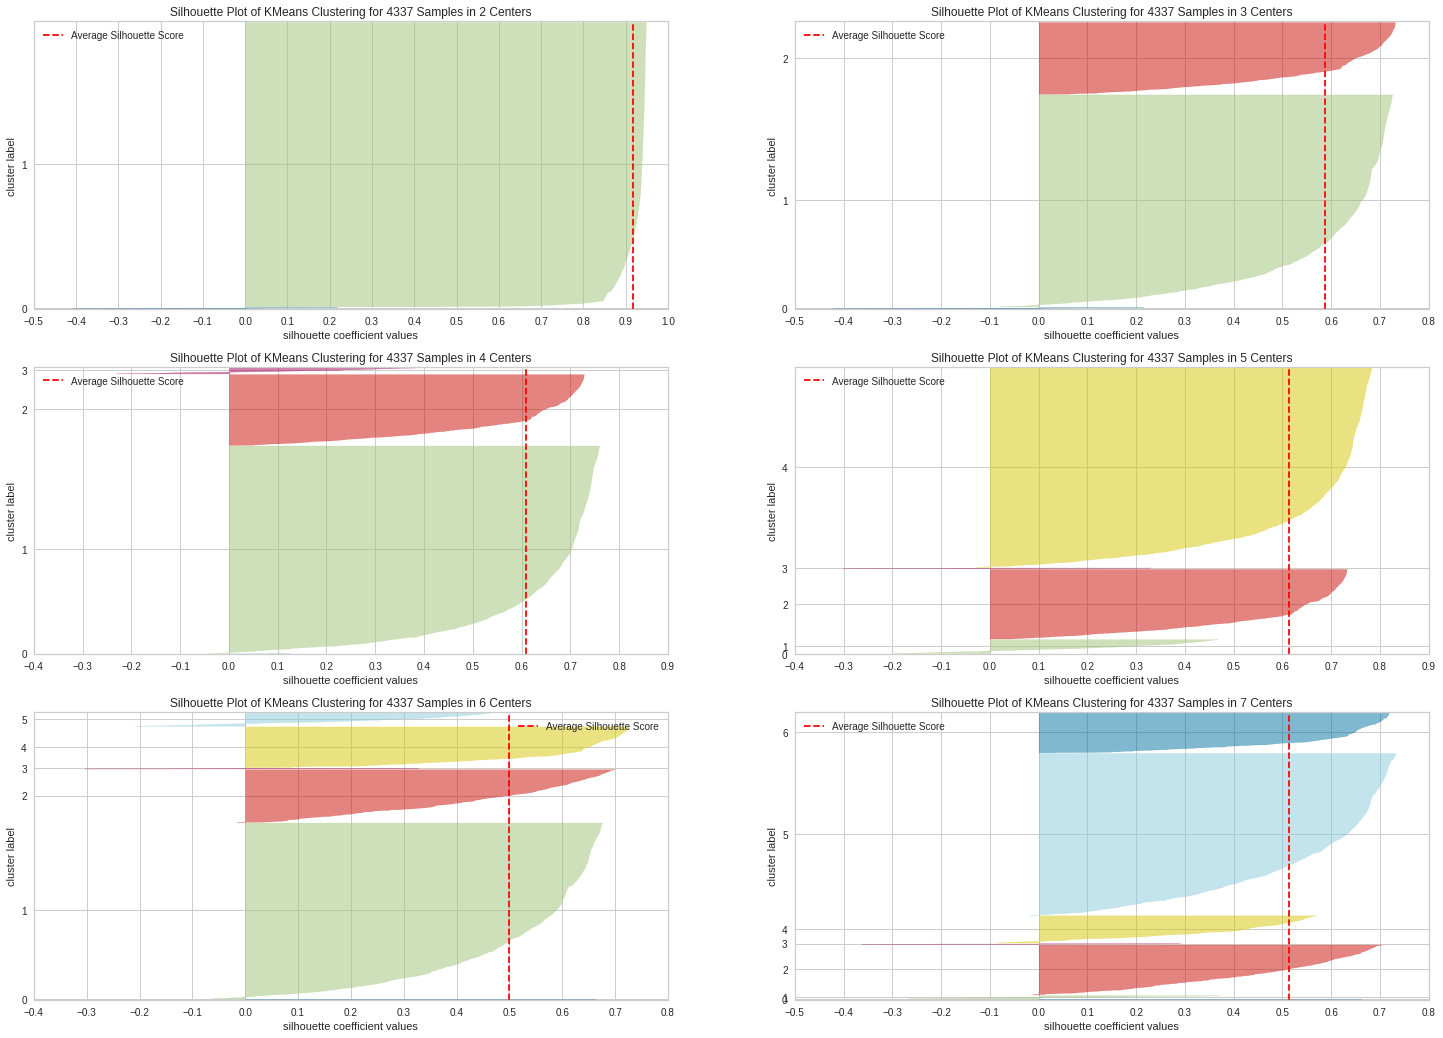

In [311]:

fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=271)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[k//2 -1][k%2])

    visualizer.fit(X)

    visualizer.finalize()

Analisando os resultados do WSS e da Silhueta vamos seguir para o Treinamento do Modelo com k = 3 (3 clusters).

# 8 Treinamento do Modelo

## 8.1 KMeans

In [312]:
# model definion
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=271)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Validation

In [313]:
# WSS
print(f'WSS Score: {kmeans.inertia_}')


# Silhouette
s = silhouette_score(X, labels, metric='euclidean')
print(f'Silhouette Score: {s}')

WSS Score: 9431.336302879605
Silhouette Score: 0.5878160951540814


# 9 Análise dos Clusters

In [314]:
df9 = df7.copy()
df9['clusters'] = labels

In [315]:
df9.head()

,customer_id,monetary,recency_days,frequency,avg_ticket,clusters
0,17850,0.376325,2.799894,3.876667,-0.034218,2
1,13047,0.135025,-0.611005,0.748478,-0.033761,1
2,12583,0.523565,-0.901081,1.400184,-0.026895,1
3,13748,-0.121469,0.029164,0.096772,-0.023514,1
4,15100,-0.129564,2.409791,-0.163911,0.152333,2


## 9.1 Inspeção por Visualização

/home/jonas/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


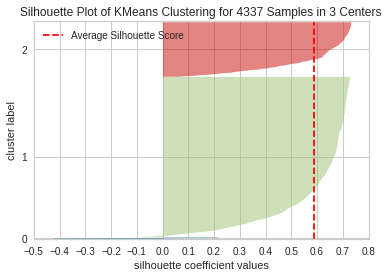

In [316]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(X)

visualizer.finalize()

## 9.2 2D Plot

In [317]:
df_viz = df9.drop('customer_id', axis=1)

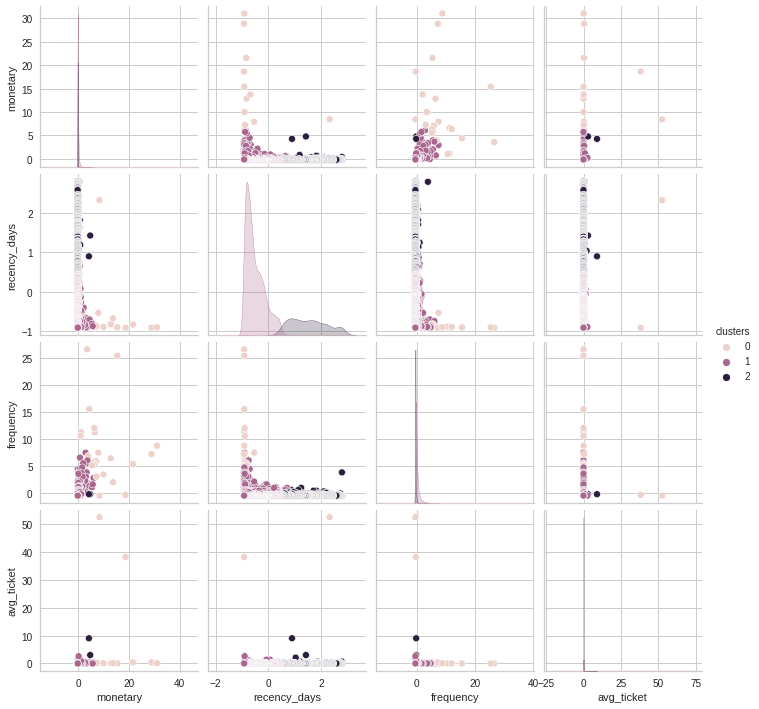

In [318]:
sns.pairplot(df_viz, hue='clusters')

## 9.3 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

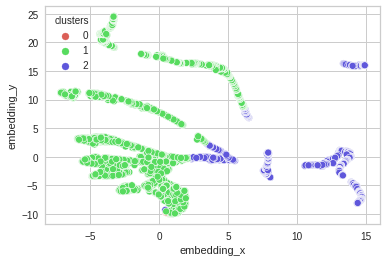

In [321]:
reducer = umap.UMAP(n_neighbors = 30, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[: , 0]
df_viz['embedding_y'] = embedding[: , 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='clusters', palette=sns.color_palette('hls', n_colors=len(df_viz['clusters'].unique())),
                data=df_viz)

## 9.2 Perfil dos Clusters

In [322]:
df9.head()

,customer_id,monetary,recency_days,frequency,avg_ticket,clusters
0,17850,0.376325,2.799894,3.876667,-0.034218,2
1,13047,0.135025,-0.611005,0.748478,-0.033761,1
2,12583,0.523565,-0.901081,1.400184,-0.026895,1
3,13748,-0.121469,0.029164,0.096772,-0.023514,1
4,15100,-0.129564,2.409791,-0.163911,0.152333,2


In [101]:
# Number of Clusters
df_clusters = df9[['customer_id', 'clusters']].groupby('clusters').count().reset_index()
df_clusters['customer_perc'] = 100*(df_clusters['customer_id'] / df_clusters['customer_id'].sum())

# AVG Monetary
df_avg_monetary = df9[['monetary', 'clusters']].groupby('clusters').mean().reset_index()
df_clusters = df_clusters.merge(df_avg_monetary, on='clusters')
df_clusters['monetary_avg_perc'] = 100*(df_clusters['monetary'] / df_clusters['monetary'].sum())

# AVG Recency_days
df_avg_recency = df9[['recency_days', 'clusters']].groupby('clusters').mean().reset_index()
df_clusters = df_clusters.merge(df_avg_recency, on='clusters')

# AVG Frequency
df_avg_freq = df9[['frequency', 'clusters']].groupby('clusters').mean().reset_index()
df_clusters = df_clusters.merge(df_avg_freq, on='clusters')

# AVG Ticket
df_avg_ticket = df9[['avg_ticket', 'clusters']].groupby('clusters').mean().reset_index()
df_clusters = df_clusters.merge(df_avg_ticket, on='clusters')

# Rename columns
df_clusters.columns = ['clusters', 'num_customer', 'customer_perc', 'monetary_avg', 'monetary_avg_perc', 'recency_days_avg', 'frequency_avg', 'avg_ticket']

In [102]:
df_clusters

,clusters,num_customer,customer_perc,monetary_avg,monetary_avg_perc,recency_days_avg,frequency_avg,avg_ticket
0,0,28,0.640439,42614.387143,18.224353,6.178571,57.821429,162.862605
1,1,267,6.107045,8089.028652,3.459332,20.280899,19.528090,62.783157
2,2,6,0.137237,182181.981667,77.911453,7.166667,89.000000,253.626345
3,3,4071,93.115279,946.696250,0.404862,96.969295,3.641120,25.359654


### **Cluster 01 (Candidatos à Insiders):**
- Número de Clientes: 6 (0.13% dos clientes)
- Receita Média: \$ 182.182,00 (77.9% da receita total)
- Ticket Médio: \$254,00
- Recência Média: 7 dias
- Frequência Média: 89 compras


### **Cluster 02:**
- Número de Clientes: 28 (0.65% dos clientes)
- Receita Média: \$ 42.614,00 (18.22% da receita total)
- Ticket Médio: \$ 163,00
- Recência Média: 6 dias
- Frequência Média: 57 compras

### **Cluster 03:**
- Número de Clientes: 267 (6.1% dos clientes)
- Receita Média: \$ 8.089,00 (3.5% da receita total)
- Ticket Médio: \$ 62,80
- Recência Média: 20 dias
- Frequência Média: 53 compras

### **Cluster 04:**
- Número de Clientes: 4071 (93.1%  dos clientes)
- Receita Média: \$ 946,00 (0.4% da receita total)
- Ticket Médio: \$ 25,00
- Recência Média: 96 dias
- Frequência Média: 4 compras


# 10 Deploy do Modelo em Produção